In [1]:
"""
Скрипт для сравнения двух методов многоклассовой классификации:
1) KNN на эмбеддингах intfloat/multilingual-e5-large
2) KNN на эмбеддингах + reranking с BAAI/bge-reranker-large,
   где «уверенность» в предсказании — это распределение классов, 
   полученное путём агрегации reranker-оценок соседей.

Перед разбиением на train/test мы группируем редкие классы (частота < 10) 
в общий класс "Другие", чтобы избежать ошибок stratify.

Входные данные: CSV-файл "/home/vadim/vadim/request_classifier/data/new/combined.csv"
- Колонки "Тема" и "Описание" объединяем в одну строку.
- Целевая метка (label) в колонке "НОМЕР".

Зависимости:
    pip install pandas numpy scikit-learn transformers torch faiss-cpu tqdm

Структура:
1. Загружаем CSV, объединяем текст и выгружаем метки.
2. Считаем частоты классов, группируем редкие (<10) в "Другие".
3. Разбиваем на train/test (80/20) стратифицированно по меткам.
4. Загружаем модель E5 (intfloat/multilingual-e5-large) и кодируем train + test тексты.
5. Строим FAISS-индекс на train-эмбеддингах.
6. Для каждой тестовой выборки:
    6.1. Метод 1 (KNN):
         - Извлекаем k ближайших соседей из train по cosine (через IndexFlatIP на L2-нормированных эмбеддингах).
         - Предсказываем label = most common среди k соседей.
         - Confidence distribution = (количество соседей каждого класса) / k.
    6.2. Метод 2 (KNN + reranker):
         - Берём тех же k соседей.
         - Для каждого соседа получаем reranker-score = BGE-reranker(query_text, neighbor_text).
         - Группируем этих k кандидатов по их классам, суммируем reranker-scores внутри каждого класса.
         - Получаем distribution по классам = (сумма reranker-score класса) / (сумма reranker-score по всем классам).
         - Предсказываем label = класс с максимальным суммарным reranker-score.
7. Считаем accuracy и macro-F1 для обоих методов на тестовой выборке.

Параметры:
    CSV_PATH      - путь до combined.csv
    EMBEDDING_MODEL - модель E5
    RERANKER_MODEL  - модель BGE-reranker
    K_NEIGHBORS     - число соседей для KNN и reranking
    TEST_SIZE       - доля тестовой выборки
    RANDOM_STATE    - random seed
    RARE_THRESHOLD  - минимальная частота, ниже которой класс считается «редким»

Запуск:
    python compare_knn_vs_rerank.py
"""

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import faiss
from collections import Counter, defaultdict
from tqdm import tqdm

###############################################################################
#                               НАСТРОЙКИ                                      #
###############################################################################

CSV_PATH = "/home/vadim/vadim/request_classifier/data/new/combined.csv"

TEXT_COLS = ["Тема", "Описание"]
TARGET_COL = "НОМЕР"

EMBEDDING_MODEL = "intfloat/multilingual-e5-large"
RERANKER_MODEL  = "BAAI/bge-reranker-large"

K_NEIGHBORS = 50  # число соседей для KNN и reranking
TEST_SIZE = 0.1
RANDOM_STATE = 42

MAX_LENGTH = 512
BATCH_SIZE = 32

RARE_THRESHOLD = 10  # классы с частотой < 10 объединяем в "Другие"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

###############################################################################
#                         ФУНКЦИИ ДЛЯ ЭМБЕДДИНГОВ                             #
###############################################################################

def embed_texts_e5(texts: list[str],
                   tokenizer_e5: AutoTokenizer,
                   model_e5: AutoModel,
                   batch_size: int = BATCH_SIZE,
                   device: str = DEVICE) -> np.ndarray:
    """
    Кодируем список текстов в эмбеддинги размерности 1024 с помощью intfloat/multilingual-e5-large.
    Возвращаем L2-нормированные вектора shape = [len(texts), 1024].
    """
    all_embeds = []
    model_e5.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="E5 Embedding"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer_e5(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model_e5(**encoded, return_dict=True)
        last_hidden = outputs.last_hidden_state  # [B, T, 1024]

        mask = encoded["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        masked = last_hidden * mask                    # [B, T, 1024]
        summed = masked.sum(dim=1)                      # [B, 1024]
        lengths = mask.sum(dim=1)                       # [B, 1]
        embeds = (summed / lengths).cpu().numpy()       # [B, 1024]

        all_embeds.append(embeds)

    all_embeds = np.vstack(all_embeds)  # [N, 1024]
    norms = np.linalg.norm(all_embeds, axis=1, keepdims=True) + 1e-12
    all_embeds = all_embeds / norms
    return all_embeds

###############################################################################
#                         ФУНКЦИИ ДЛЯ RERANKER-а                               #
###############################################################################

def rerank_scores_bge(query: str,
                      neighbor_texts: list[str],
                      tokenizer_rerank: AutoTokenizer,
                      model_rerank: AutoModelForSequenceClassification,
                      device: str = DEVICE) -> list[float]:
    """
    Для одного query и списка текстов-соседей возвращаем reranker-оценки (scores) для каждой пары.
    Используем BGE-reranker-large.
    Возвращаем список float, len = len(neighbor_texts).
    """
    model_rerank.eval()
    pairs = [(query, doc) for doc in neighbor_texts]
    encoded = tokenizer_rerank.batch_encode_plus(
        pairs,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model_rerank(**encoded)
    logits = outputs.logits.cpu().numpy()  # [K, num_labels]

    # Если два лейбла (релевантно/нерелевантно), берём softmax probability положительного
    if logits.shape[1] == 2:
        exp = np.exp(logits)
        probs = exp[:, 1] / exp.sum(axis=1)  # [K]
        scores = probs.tolist()
    else:
        # один логит
        scores = logits[:, 0].tolist()

    return scores  # length K

###############################################################################
#                            MAIN: ЗАГРУЗКА ДАННЫХ                              #
###############################################################################

if __name__ == "__main__":
    # 1) Загрузка CSV
    print("Loading CSV...")
    df = pd.read_csv(CSV_PATH)
    for col in TEXT_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in CSV")

    # 2) Объединяем "Тема" + "Описание" в одну строку
    print("Combining text columns...")
    df["text"] = df[TEXT_COLS[0]].fillna("") + " " + df[TEXT_COLS[1]].fillna("")

    # 3) Обрабатываем метки
    if not pd.api.types.is_integer_dtype(df[TARGET_COL].dtype):
        try:
            df[TARGET_COL] = df[TARGET_COL].astype(int)
        except:
            df[TARGET_COL] = df[TARGET_COL].astype(str)
    labels = df[TARGET_COL].tolist()
    texts = df["text"].tolist()

    # 4) Группировка редких классов в "Другие"
    print("Grouping rare classes (freq < {RARE_THRESHOLD}) into 'Другие'...")
    freq = Counter(labels)
    grouped_labels = []
    for lab in labels:
        if freq[lab] < RARE_THRESHOLD:
            grouped_labels.append("Другие")
        else:
            grouped_labels.append(lab)

    # Пересчитываем частоты после группировки
    freq_grouped = Counter(grouped_labels)
    print(f"After grouping, class frequencies: {freq_grouped.most_common(10)} ...")

    # 5) Строим словарь классов (уникальные)
    unique_classes = sorted(freq_grouped.keys())
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    # 6) Преобразуем метки в индексы
    y = np.array([class_to_idx[l] for l in grouped_labels], dtype=int)
    n_classes = len(unique_classes)
    print(f"Total samples: {len(texts)}, Unique classes after grouping: {n_classes}")

    # 7) Разбиение на train/test
    print("Splitting into train/test...")
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

    # 8) Загружаем E5 для эмбеддингов
    print(f"Loading E5 model ({EMBEDDING_MODEL}) ...")
    tokenizer_e5 = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
    model_e5 = AutoModel.from_pretrained(EMBEDDING_MODEL).to(DEVICE)

    # 9) Кодируем train и test тексты
    print("Embedding train texts with E5...")
    X_train_vecs = embed_texts_e5(X_train_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)
    print("Embedding test texts with E5...")
    X_test_vecs = embed_texts_e5(X_test_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)

    # 10) Строим FAISS-индекс (Inner Product на L2-нормированных векторах)
    print("Building FAISS index on train embeddings...")
    d = X_train_vecs.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(X_train_vecs.astype(np.float32))

    # 11) Загружаем reranker (BGE-reranker-large)
    print(f"Loading reranker model ({RERANKER_MODEL}) ...")
    tokenizer_rerank = AutoTokenizer.from_pretrained(RERANKER_MODEL)
    model_rerank = AutoModelForSequenceClassification.from_pretrained(RERANKER_MODEL).to(DEVICE)

    # 12) Классификация тестовой выборки
    preds_knn = []
    preds_rerank = []
    dist_knn = []
    dist_rerank = []

    print("Classifying test samples...")
    for i in tqdm(range(len(X_test_vecs)), desc="Test samples"):
        q_vec = X_test_vecs[i].reshape(1, -1).astype(np.float32)

        # KNN: получаем K_NEIGHBORS соседей
        _, knn_indices = index.search(q_vec, K_NEIGHBORS)
        knn_ids = knn_indices[0].tolist()

        # Метод 1: KNN без reranker
        neighbor_labels = [y_train[idx] for idx in knn_ids]
        counter = Counter(neighbor_labels)
        pred_knn = counter.most_common(1)[0][0]
        preds_knn.append(pred_knn)

        # Confidence distribution для KNN (counts / K_NEIGHBORS)
        dist_knn_i = np.zeros(n_classes, dtype=float)
        for lbl, cnt in counter.items():
            dist_knn_i[lbl] = cnt / K_NEIGHBORS
        dist_knn.append(dist_knn_i)

        # Метод 2: KNN + rerank
        neighbor_texts = [X_train_texts[idx] for idx in knn_ids]
        # Получаем reranker-scores
        scores = rerank_scores_bge(
            X_test_texts[i],
            neighbor_texts,
            tokenizer_rerank,
            model_rerank,
            device=DEVICE
        )
        # Агрегируем reranker-scores по классам
        agg_scores = np.zeros(n_classes, dtype=float)
        for idx_neighbor, score in zip(knn_ids, scores):
            cls = y_train[idx_neighbor]
            agg_scores[cls] += score

        total_score = agg_scores.sum()
        if total_score > 0:
            dist_rerank_i = agg_scores / total_score
        else:
            dist_rerank_i = np.ones(n_classes, dtype=float) / n_classes
        dist_rerank.append(dist_rerank_i)

        pred_rerank = int(np.argmax(dist_rerank_i))
        preds_rerank.append(pred_rerank)

    # 13) Оценка качества
    y_true = y_test
    y_pred_knn = np.array(preds_knn, dtype=int)
    y_pred_rerank = np.array(preds_rerank, dtype=int)

    acc_knn = accuracy_score(y_true, y_pred_knn)
    f1_knn  = f1_score(y_true, y_pred_knn, average="macro")
    acc_rerank = accuracy_score(y_true, y_pred_rerank)
    f1_rerank  = f1_score(y_true, y_pred_rerank, average="macro")

    print("\n===== Results =====")
    print(f"KNN + E5 only       : Accuracy = {acc_knn:.4f}, Macro-F1 = {f1_knn:.4f}")
    print(f"KNN + E5 + Reranker : Accuracy = {acc_rerank:.4f}, Macro-F1 = {f1_rerank:.4f}")

    print("\n--- Classification Report for KNN ---")
    print(classification_report(y_true, y_pred_knn, target_names=[str(c) for c in unique_classes]))

    print("\n--- Classification Report for Reranker ---")
    print(classification_report(y_true, y_pred_rerank, target_names=[str(c) for c in unique_classes]))

    # (Опционально: сохранить distributions для анализа)
    # np.save("dist_knn.npy", np.vstack(dist_knn))
    # np.save("dist_rerank.npy", np.vstack(dist_rerank))

    print("Done.")


/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CSV...
Combining text columns...
Grouping rare classes (freq < {RARE_THRESHOLD}) into 'Другие'...
After grouping, class frequencies: [('SRV0000736', 939), ('Другие', 749), ('SRV0000875', 707), ('SRV0000738', 684), ('SRV0000508', 524), ('SRV0000507', 404), ('SRV0000873', 402), ('SRV0000760', 399), ('SRV0000482', 227), ('SRV0000743', 207)] ...
Total samples: 11185, Unique classes after grouping: 141
Splitting into train/test...
Train size: 10066, Test size: 1119
Loading E5 model (intfloat/multilingual-e5-large) ...
Embedding train texts with E5...


E5 Embedding: 100%|██████████| 315/315 [02:10<00:00,  2.41it/s]


Embedding test texts with E5...


E5 Embedding: 100%|██████████| 35/35 [00:16<00:00,  2.16it/s]


Building FAISS index on train embeddings...
Loading reranker model (BAAI/bge-reranker-large) ...
Classifying test samples...


Test samples: 100%|██████████| 1119/1119 [11:48<00:00,  1.58it/s]


===== Results =====
KNN + E5 only       : Accuracy = 0.4683, Macro-F1 = 0.1866
KNN + E5 + Reranker : Accuracy = 0.1850, Macro-F1 = 0.0897

--- Classification Report for KNN ---
              precision    recall  f1-score   support

  SRV0000267       0.00      0.00      0.00         2
  SRV0000268       1.00      0.10      0.18        10
  SRV0000271       0.00      0.00      0.00         2
  SRV0000273       0.00      0.00      0.00         3
  SRV0000274       0.50      0.68      0.58        19
  SRV0000279       1.00      0.33      0.50         3
  SRV0000285       0.00      0.00      0.00         5
  SRV0000286       0.00      0.00      0.00         2
  SRV0000450       0.00      0.00      0.00         1
  SRV0000482       0.53      0.91      0.67        23
  SRV0000483       0.00      0.00      0.00         1
  SRV0000484       0.00      0.00      0.00         3
  SRV0000486       0.50      0.17      0.25         6
  SRV0000503       0.78      0.93      0.85        15
  SRV000050


/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CSV...
Combining text columns...
Grouping classes with frequency < 10 into 'Другие'...
Total samples: 2000, Unique classes after grouping: 46
Splitting into train/test...
Train size: 1600, Test size: 400
Loading E5 model (intfloat/multilingual-e5-large) ...
Embedding train texts with E5...


E5 Embedding: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Embedding test texts with E5...


E5 Embedding: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


Initializing KNNClassifierService...
Loading reranker model (BAAI/bge-reranker-large) ...
Initializing RerankerClassifierService...
Classifying test samples...

===== Results =====
KNN only              : Accuracy = 0.4375, Macro-F1 = 0.1819
KNN + Reranker        : Accuracy = 0.3175, Macro-F1 = 0.0832

--- Classification Report for KNN ---
              precision    recall  f1-score   support

  SRV0000268       0.00      0.00      0.00         5
  SRV0000274       0.70      0.88      0.78         8
  SRV0000482       0.64      0.88      0.74         8
  SRV0000503       0.67      0.80      0.73         5
  SRV0000504       0.00      0.00      0.00         4
  SRV0000507       0.26      0.60      0.37        15
  SRV0000508       0.14      0.14      0.14        21
  SRV0000734       0.00      0.00      0.00         6
  SRV0000736       0.37      0.78      0.50        36
  SRV0000737       0.00      0.00      0.00         6
  SRV0000738       0.42      0.42      0.42        24
  SRV0000

/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

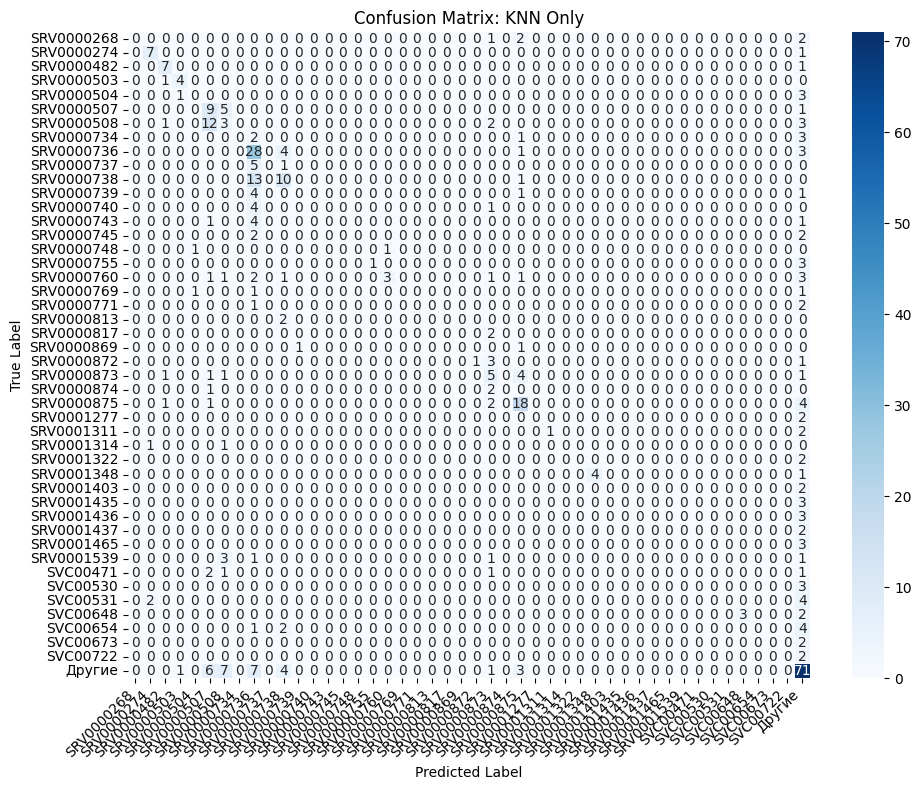

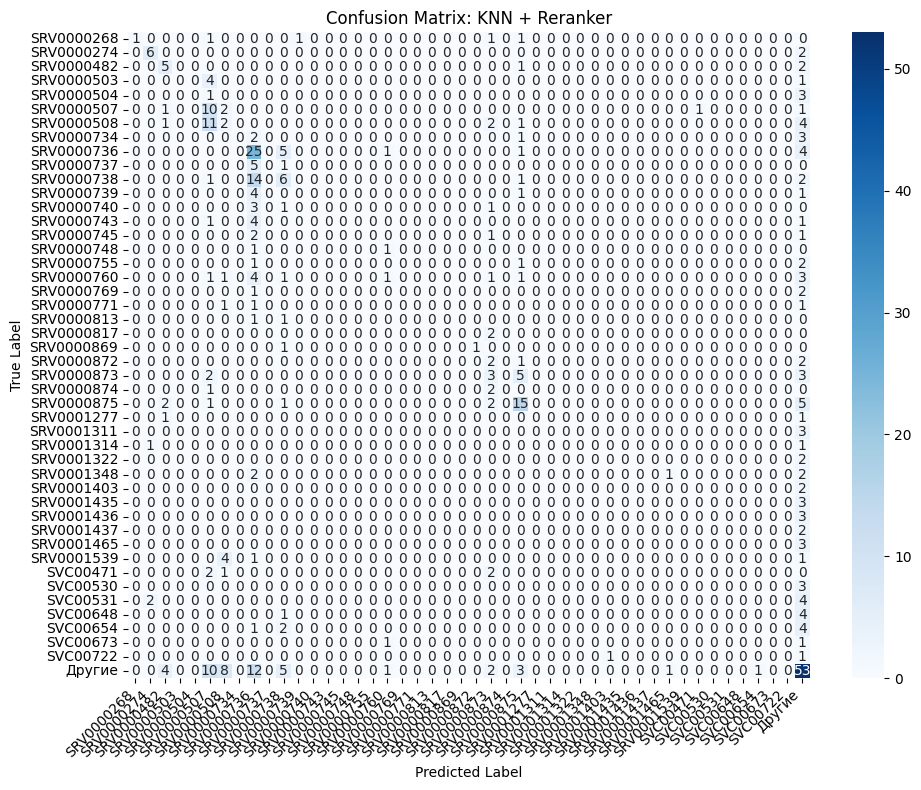

Done.


In [ ]:
"""
Расширенный пайплайн классификации с двумя подходами:
1) KNN-классификатор на FAISS (учитывает расстояние соседей)
2) KNN + reranker-классификатор (BAAI/bge-reranker-large), 
   где веса берутся из reranker-score соседей.

Кроме того, отображаем confusion matrix для обоих методов.

Рабочий процесс:
- Загружаем данные и объединяем колонки "Тема" + "Описание".
- Группируем редкие классы (частота < RARE_THRESHOLD) в "Другие".
- Разбиваем на train/test.
- Кодируем тексты через E5 (intfloat/multilingual-e5-large).
- Строим FAISS-индекс на train-эмбеддингах.
- Определяем два сервиса:
   * KNNClassifierService: предсказывает на основе k ближайших соседей (взвешивает по cosine-расстоянию).
   * RerankerClassifierService: сначала получает k соседей из FAISS, затем rerank’ит их через BGE-reranker, агрегирует reranker-оценки по классам.
- Применяем оба сервиса к тестовой выборке, сохраняем предсказания.
- Вычисляем accuracy и macro-F1 для обоих.
- Строим и показываем confusion matrix.

Зависимости:
    pip install pandas numpy scikit-learn transformers torch faiss-cpu matplotlib seaborn tqdm

Запуск:
    python classify_with_services.py
"""

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import faiss
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

###############################################################################
#                               НАСТРОЙКИ                                      #
###############################################################################

CSV_PATH = "/home/vadim/vadim/request_classifier/data/new/combined.csv"

TEXT_COLS = ["Тема", "Описание"]
TARGET_COL = "НОМЕР"

EMBEDDING_MODEL = "intfloat/multilingual-e5-large"
EMBEDDING_MODEL = 'BAAI/bge-m3'
RERANKER_MODEL  = "BAAI/bge-reranker-large"

K_NEIGHBORS = 50
TEST_SIZE = 0.2
RANDOM_STATE = 42

MAX_LENGTH = 512
BATCH_SIZE = 32

RARE_THRESHOLD = 10  # классы с частотой < 10 объединяем в "Другие"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

###############################################################################
#                         ФУНКЦИИ ДЛЯ ЭМБЕДДИНГОВ                             #
###############################################################################

def embed_texts_e5(texts: list[str],
                   tokenizer_e5: AutoTokenizer,
                   model_e5: AutoModel,
                   batch_size: int = BATCH_SIZE,
                   device: str = DEVICE) -> np.ndarray:
    """
    Кодируем список текстов в эмбеддинги размерности 1024 с помощью intfloat/multilingual-e5-large.
    Возвращаем L2-нормированные вектора shape = [len(texts), 1024].
    """
    all_embeds = []
    model_e5.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="E5 Embedding"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer_e5(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model_e5(**encoded, return_dict=True)
        last_hidden = outputs.last_hidden_state  # [B, T, 1024]

        mask = encoded["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        masked = last_hidden * mask                    # [B, T, 1024]
        summed = masked.sum(dim=1)                      # [B, 1024]
        lengths = mask.sum(dim=1)                       # [B, 1]
        embeds = (summed / lengths).cpu().numpy()       # [B, 1024]

        all_embeds.append(embeds)

    all_embeds = np.vstack(all_embeds)  # [N, 1024]
    norms = np.linalg.norm(all_embeds, axis=1, keepdims=True) + 1e-12
    all_embeds = all_embeds / norms
    return all_embeds

###############################################################################
#                       СЕРВИСЫ КЛАССИФИКАЦИИ                                  #
###############################################################################

class KNNClassifierService:
    """
    Классификатор на основе KNN через FAISS, взвешивает соседей 
    по cosine (inner-product на L2-нормированных эмбеддингах).
    """
    def __init__(self, train_vecs: np.ndarray, train_labels: np.ndarray, k: int = K_NEIGHBORS):
        self.k = k
        self.train_labels = train_labels
        # Строим FAISS-индекс на train_vecs
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def predict_one(self, query_vec: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Для одного вектора query_vec возвращает кортеж (pred_label, distribution),
        где distribution — вероятности по классам (L2-нормированные косинусные схожести).
        """
        qv = query_vec.reshape(1, -1).astype(np.float32)
        similarities, indices = self.index.search(qv, self.k)
        sims = similarities[0]        # [k]
        neigh_ids = indices[0].tolist()  # [k]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]
        # Взвешивание: суммируем cosine-similiarty для каждого класса
        class_scores = defaultdict(float)
        total_sim = 0.0
        for lbl, sim in zip(neigh_labels, sims):
            class_scores[lbl] += sim
            total_sim += sim
        if total_sim == 0:
            # fallback: простое голосование
            counts = Counter(neigh_labels)
            pred = counts.most_common(1)[0][0]
            dist = np.zeros(len(np.unique(self.train_labels)), dtype=float)
            for lbl, cnt in counts.items():
                dist[lbl] = cnt / self.k
        else:
            pred = max(class_scores.items(), key=lambda x: x[1])[0]
            # нормируем по сумме
            dist = np.zeros(len(np.unique(self.train_labels)), dtype=float)
            for lbl, score in class_scores.items():
                dist[lbl] = score / total_sim
        return int(pred), dist

    def predict(self, query_vecs: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Для массива query_vecs ([N, dim]) возвращает кортеж (preds, dists),
        где preds = [N] предсказания, dists = [N, num_classes] распределения.
        """
        preds = []
        dists = []
        for vec in query_vecs:
            p, dist = self.predict_one(vec)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)


class RerankerClassifierService:
    """
    Классификатор, который сперва получает k соседей из FAISS, 
    потом rerank’ит их через BGE-reranker и агрегирует reranker-оценки по классам.
    """
    def __init__(self,
                 train_vecs: np.ndarray,
                 train_labels: np.ndarray,
                 train_texts: List[str],
                 tokenizer_rerank: AutoTokenizer,
                 model_rerank: AutoModelForSequenceClassification,
                 k: int = K_NEIGHBORS,
                 device: str = DEVICE):
        self.k = k
        self.train_labels = train_labels
        self.train_texts = train_texts
        self.tokenizer_rerank = tokenizer_rerank
        self.model_rerank = model_rerank.to(device)
        self.device = device
        # Строим FAISS-индекс
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def rerank_scores(self, query: str, neighbor_texts: List[str]) -> List[float]:
        """
        Использует BGE-reranker, чтобы получить список оценок для каждой пары (query, neighbor_text).
        """
        self.model_rerank.eval()
        pairs = [(query, doc) for doc in neighbor_texts]
        encoded = self.tokenizer_rerank.batch_encode_plus(
            pairs,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model_rerank(**encoded)
        logits = outputs.logits.cpu().numpy()  # [k, num_labels]
        if logits.shape[1] == 2:
            exp = np.exp(logits)
            probs = exp[:, 1] / exp.sum(axis=1)
            return probs.tolist()
        else:
            return logits[:, 0].tolist()

    def predict_one(self, query_vec: np.ndarray, query_text: str, num_classes: int) -> tuple[int, np.ndarray]:
        """
        Для одного query_vec и query_text возвращает (pred_label, distribution).
        """
        qv = query_vec.reshape(1, -1).astype(np.float32)
        sims, indices = self.index.search(qv, self.k)
        neigh_ids = indices[0].tolist()     # [k]
        neigh_texts = [self.train_texts[idx] for idx in neigh_ids]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]

        # Получаем reranker-scores
        scores = self.rerank_scores(query_text, neigh_texts)  # [k]

        # Агрегируем reranker-scores по классам
        class_scores = np.zeros(num_classes, dtype=float)
        for lbl, sc in zip(neigh_labels, scores):
            class_scores[lbl] += sc
        total_score = class_scores.sum()
        if total_score == 0:
            # fallback: равномерный
            dist = np.ones(num_classes, dtype=float) / num_classes
            pred = np.random.randint(0, num_classes)
        else:
            dist = class_scores / total_score
            pred = int(np.argmax(dist))
        return pred, dist

    def predict(self, query_vecs: np.ndarray, query_texts: List[str], num_classes: int) -> tuple[np.ndarray, np.ndarray]:
        """
        Для массива query_vecs ([N, dim]) и query_texts ([N]) возвращает (preds, dists).
        """
        preds = []
        dists = []
        for vec, txt in tqdm(zip(query_vecs, query_texts)):
            p, dist = self.predict_one(vec, txt, num_classes)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)

###############################################################################
#                         ФУНКЦИИ ДЛЯ ВИЗУАЛИЗАЦИИ                             #
###############################################################################

def plot_confusion(cm: np.ndarray, class_labels: List[str], title: str):
    """
    Строит график confusion matrix с метками.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

###############################################################################
#                                    MAIN                                      #
###############################################################################

if __name__ == "__main__":
    # 1) Загрузка CSV
    print("Loading CSV...")
    df = pd.read_csv(CSV_PATH).sample(2000)
    for col in TEXT_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in CSV")

    # 2) Объединяем "Тема" + "Описание"
    print("Combining text columns...")
    df["text"] = df[TEXT_COLS[0]].fillna("") + " " + df[TEXT_COLS[1]].fillna("")

    # 3) Обрабатываем метки
    if not pd.api.types.is_integer_dtype(df[TARGET_COL].dtype):
        try:
            df[TARGET_COL] = df[TARGET_COL].astype(int)
        except:
            df[TARGET_COL] = df[TARGET_COL].astype(str)
    original_labels = df[TARGET_COL].tolist()
    texts = df["text"].tolist()

    # 4) Группировка редких классов
    print(f"Grouping classes with frequency < {RARE_THRESHOLD} into 'Другие'...")
    freq = Counter(original_labels)
    grouped_labels = []
    for lab in original_labels:
        if freq[lab] < RARE_THRESHOLD:
            grouped_labels.append("Другие")
        else:
            grouped_labels.append(lab)

    # 5) Список уникальных классов после группировки
    freq_grouped = Counter(grouped_labels)
    unique_classes = sorted(freq_grouped.keys())
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    y = np.array([class_to_idx[l] for l in grouped_labels], dtype=int)
    n_classes = len(unique_classes)
    print(f"Total samples: {len(texts)}, Unique classes after grouping: {n_classes}")

    # 6) Разбиение на train/test
    print("Splitting into train/test...")
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

    # 7) Загрузка E5 и кодирование текстов
    print(f"Loading E5 model ({EMBEDDING_MODEL}) ...")
    tokenizer_e5 = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
    model_e5 = AutoModel.from_pretrained(EMBEDDING_MODEL).to(DEVICE)

    print("Embedding train texts with E5...")
    X_train_vecs = embed_texts_e5(X_train_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)
    print("Embedding test texts with E5...")
    X_test_vecs = embed_texts_e5(X_test_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)

    # 8) Инициализация сервисов
    print("Initializing KNNClassifierService...")
    knn_service = KNNClassifierService(train_vecs=X_train_vecs, train_labels=y_train, k=K_NEIGHBORS)

    print(f"Loading reranker model ({RERANKER_MODEL}) ...")
    tokenizer_rerank = AutoTokenizer.from_pretrained(RERANKER_MODEL)
    model_rerank = AutoModelForSequenceClassification.from_pretrained(RERANKER_MODEL).to(DEVICE)

    print("Initializing RerankerClassifierService...")
    rerank_service = RerankerClassifierService(
        train_vecs=X_train_vecs,
        train_labels=y_train,
        train_texts=X_train_texts,
        tokenizer_rerank=tokenizer_rerank,
        model_rerank=model_rerank,
        k=K_NEIGHBORS,
        device=DEVICE
    )

    # 9) Предсказания на тесте
    print("Classifying test samples...")
    preds_knn, dists_knn = knn_service.predict(X_test_vecs)
    preds_rerank, dists_rerank = rerank_service.predict(X_test_vecs, X_test_texts, n_classes)

    # 10) Оценка качества
    y_true = y_test
    y_pred_knn = preds_knn
    y_pred_rerank = preds_rerank

    acc_knn = accuracy_score(y_true, y_pred_knn)
    f1_knn  = f1_score(y_true, y_pred_knn, average="macro")
    acc_rerank = accuracy_score(y_true, y_pred_rerank)
    f1_rerank  = f1_score(y_true, y_pred_rerank, average="macro")

    print("\n===== Results =====")
    print(f"KNN only              : Accuracy = {acc_knn:.4f}, Macro-F1 = {f1_knn:.4f}")
    print(f"KNN + Reranker        : Accuracy = {acc_rerank:.4f}, Macro-F1 = {f1_rerank:.4f}")

    print("\n--- Classification Report for KNN ---")
    print(classification_report(y_true, y_pred_knn, target_names=unique_classes))

    print("\n--- Classification Report for KNN + Reranker ---")
    print(classification_report(y_true, y_pred_rerank, target_names=unique_classes))

    # 11) Построение confusion matrix
    cm_knn = confusion_matrix(y_true, y_pred_knn)
    cm_rerank = confusion_matrix(y_true, y_pred_rerank)

    plot_confusion(cm_knn, unique_classes, title="Confusion Matrix: KNN Only")
    plot_confusion(cm_rerank, unique_classes, title="Confusion Matrix: KNN + Reranker")

    print("Done.")


In [2]:
y_pred_rerank

array([45, 10,  8,  6, 45,  8, 45,  1, 45, 45,  8,  8, 10,  8, 45,  8,  8,
        5,  5,  8, 45,  5, 45,  5, 10, 45, 45,  6, 45, 10,  6,  8,  8, 45,
       45, 26, 10,  6, 10, 26,  1,  8, 26,  6, 10,  6,  5,  2,  8, 45,  5,
        8,  2, 45,  5, 17, 45, 42, 17,  5, 24, 45,  8, 45,  6, 45, 10, 45,
       45, 45, 26, 24, 24, 10,  8, 26,  5, 45, 45, 45, 26, 45,  5, 24, 26,
        8, 45, 45, 45,  0,  1, 26,  8,  8,  2, 45, 45,  8,  8, 45,  8, 26,
       45,  5, 45, 11, 45,  8,  5,  8,  8, 23, 10, 10,  6,  5, 24,  5,  8,
       45,  8, 26, 45,  8,  5,  8,  8,  5, 10, 45, 24, 45,  5,  8, 45, 10,
       45,  5, 10, 45, 45,  8, 45, 45,  8,  8, 45,  5, 36, 45,  8,  6,  8,
       45, 17,  5,  5,  8, 45,  5, 45, 45, 45,  5,  8, 45, 26, 45,  1, 45,
       45, 45, 45, 45, 45, 45, 26, 45, 45, 45, 26,  2,  5,  1, 45, 45, 45,
        8,  8,  8, 26,  2, 32, 26,  8, 45,  6,  8, 45, 45, 26,  6, 26,  8,
        8,  5,  8, 45,  8, 45, 45, 45,  5, 10, 36,  5, 10,  8, 26, 24,  8,
       45, 45,  8, 45,  2

In [12]:
dists_rerank[6]

array([-0.        ,  0.02270099, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.02933242, -0.        ,
       -0.        ,  0.0360502 , -0.        , -0.        ,  0.03791151,
       -0.        , -0.        ,  0.02111354, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.0610254 , -0.        ,  0.0834949 ,  0.02347277,
        0.00946368, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.00197838,
        0.17799247, -0.        , -0.        , -0.        , -0.        ,
        0.4994205 ])

/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CSV...
Combining text columns...
Grouping classes with frequency < 10 into 'Другие'...
Total samples: 2000, Unique classes after grouping: 48
Splitting into train/test...
Train size: 1600, Test size: 400
Loading E5 model (BAAI/bge-m3) ...
Embedding train texts with E5...


E5 Embedding: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


Embedding test texts with E5...


E5 Embedding: 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Initializing KNNClassifierService...
Loading reranker model (BAAI/bge-reranker-large) ...
Initializing RerankerClassifierService...
Classifying test samples...


100%|██████████| 400/400 [03:57<00:00,  1.68it/s]
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to


===== Results =====
KNN only              : Accuracy = 0.4425, Macro-F1 = 0.1737
KNN + Reranker        : Accuracy = 0.2950, Macro-F1 = 0.0788

--- Classification Report for KNN ---
              precision    recall  f1-score   support

  SRV0000268       0.00      0.00      0.00         3
  SRV0000274       0.43      0.43      0.43         7
  SRV0000285       0.00      0.00      0.00         2
  SRV0000482       0.61      1.00      0.76        11
  SRV0000486       0.00      0.00      0.00         2
  SRV0000503       1.00      1.00      1.00         6
  SRV0000504       0.00      0.00      0.00         2
  SRV0000507       0.38      0.67      0.48        12
  SRV0000508       0.23      0.33      0.27        18
  SRV0000734       0.00      0.00      0.00         6
  SRV0000736       0.51      0.58      0.54        33
  SRV0000737       1.00      0.17      0.29         6
  SRV0000738       0.41      0.82      0.55        22
  SRV0000739       0.00      0.00      0.00         6
  SRV00

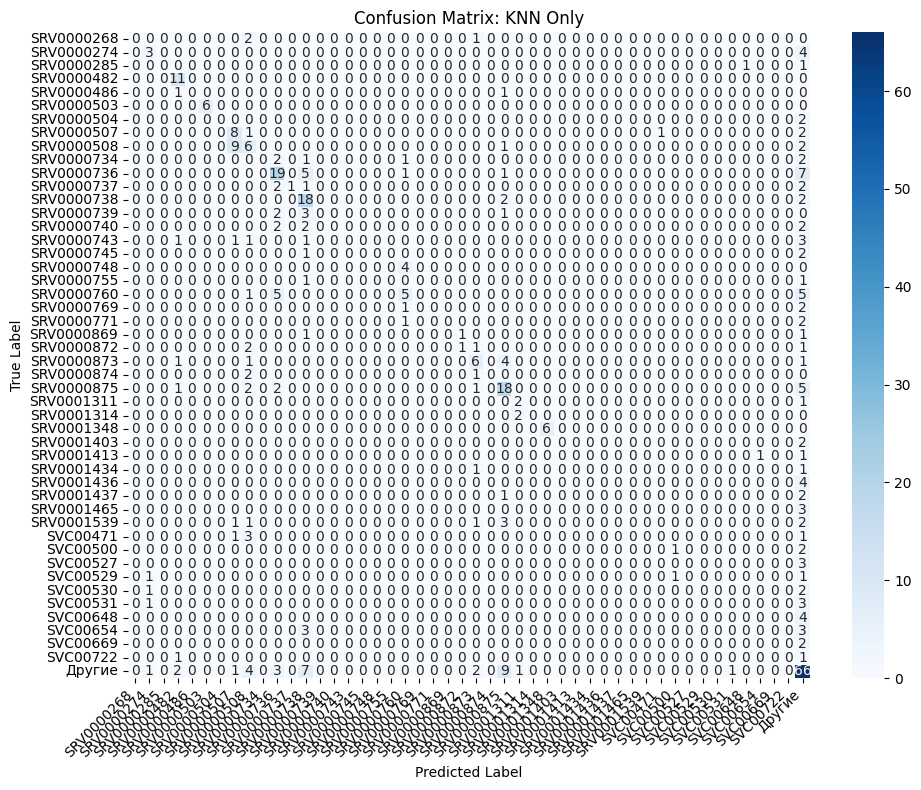

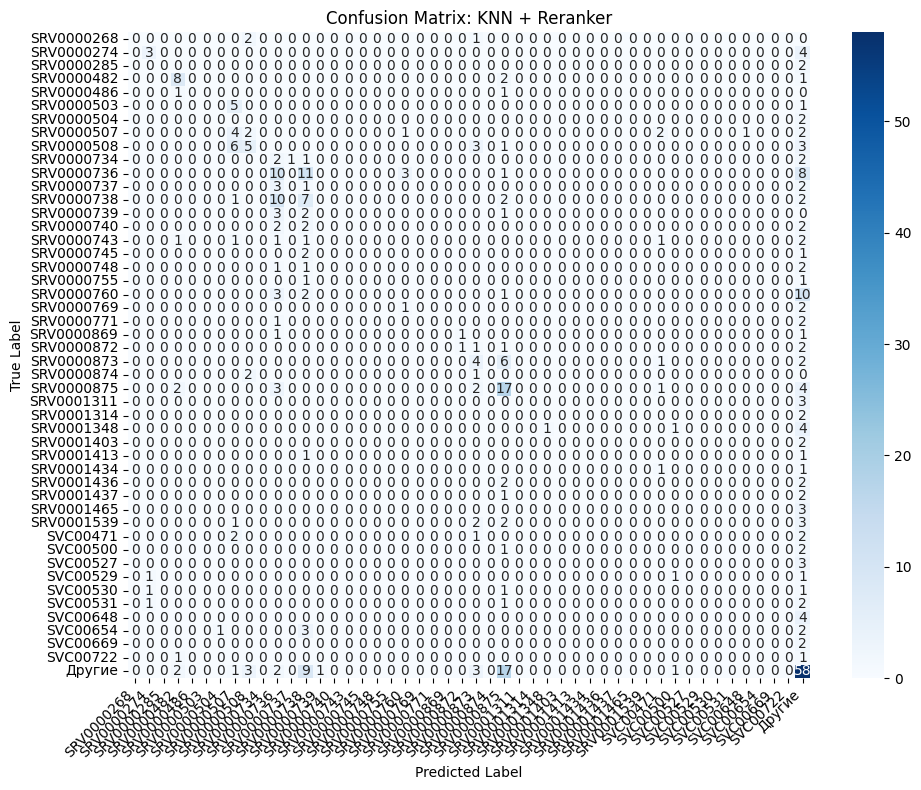

Done.


In [1]:
"""
Расширенный пайплайн классификации с двумя подходами:
1) KNN-классификатор на FAISS (учитывает расстояние соседей)
2) KNN + reranker-классификатор (BAAI/bge-reranker-large), 
   где веса берутся из reranker-score соседей.

Кроме того, отображаем confusion matrix для обоих методов.

Рабочий процесс:
- Загружаем данные и объединяем колонки "Тема" + "Описание".
- Группируем редкие классы (частота < RARE_THRESHOLD) в "Другие".
- Разбиваем на train/test.
- Кодируем тексты через E5 (intfloat/multilingual-e5-large).
- Строим FAISS-индекс на train-эмбеддингах.
- Определяем два сервиса:
   * KNNClassifierService: предсказывает на основе k ближайших соседей (взвешивает по cosine-расстоянию).
   * RerankerClassifierService: сначала получает k соседей из FAISS, затем rerank’ит их через BGE-reranker, агрегирует reranker-оценки по классам.
- Применяем оба сервиса к тестовой выборке, сохраняем предсказания.
- Вычисляем accuracy и macro-F1 для обоих.
- Строим и показываем confusion matrix.

Зависимости:
    pip install pandas numpy scikit-learn transformers torch faiss-cpu matplotlib seaborn tqdm

Запуск:
    python classify_with_services.py
"""

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import faiss
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

###############################################################################
#                               НАСТРОЙКИ                                      #
###############################################################################

CSV_PATH = "/home/vadim/vadim/request_classifier/data/new/combined.csv"

TEXT_COLS = ["Тема", "Описание"]
TARGET_COL = "НОМЕР"

EMBEDDING_MODEL = "intfloat/multilingual-e5-large"
EMBEDDING_MODEL = 'BAAI/bge-m3'
RERANKER_MODEL  = "BAAI/bge-reranker-large"

K_NEIGHBORS = 50
TEST_SIZE = 0.2
RANDOM_STATE = 42

MAX_LENGTH = 512
BATCH_SIZE = 32

RARE_THRESHOLD = 10  # классы с частотой < 10 объединяем в "Другие"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

###############################################################################
#                         ФУНКЦИИ ДЛЯ ЭМБЕДДИНГОВ                             #
###############################################################################

def embed_texts_e5(texts: list[str],
                   tokenizer_e5: AutoTokenizer,
                   model_e5: AutoModel,
                   batch_size: int = BATCH_SIZE,
                   device: str = DEVICE) -> np.ndarray:
    """
    Кодируем список текстов в эмбеддинги размерности 1024 с помощью intfloat/multilingual-e5-large.
    Возвращаем L2-нормированные вектора shape = [len(texts), 1024].
    """
    all_embeds = []
    model_e5.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="E5 Embedding"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer_e5(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model_e5(**encoded, return_dict=True)
        last_hidden = outputs.last_hidden_state  # [B, T, 1024]

        mask = encoded["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        masked = last_hidden * mask                    # [B, T, 1024]
        summed = masked.sum(dim=1)                      # [B, 1024]
        lengths = mask.sum(dim=1)                       # [B, 1]
        embeds = (summed / lengths).cpu().numpy()       # [B, 1024]

        all_embeds.append(embeds)

    all_embeds = np.vstack(all_embeds)  # [N, 1024]
    norms = np.linalg.norm(all_embeds, axis=1, keepdims=True) + 1e-12
    all_embeds = all_embeds / norms
    return all_embeds

###############################################################################
#                       СЕРВИСЫ КЛАССИФИКАЦИИ                                  #
###############################################################################

class KNNClassifierService:
    """
    Классификатор на основе KNN через FAISS, взвешивает соседей 
    по cosine (inner-product на L2-нормированных эмбеддингах).
    """
    def __init__(self, train_vecs: np.ndarray, train_labels: np.ndarray, k: int = K_NEIGHBORS):
        self.k = k
        self.train_labels = train_labels
        # Строим FAISS-индекс на train_vecs
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def predict_one(self, query_vec: np.ndarray) -> tuple[int, np.ndarray]:
        """
        Для одного вектора query_vec возвращает кортеж (pred_label, distribution),
        где distribution — вероятности по классам (L2-нормированные косинусные схожести).
        """
        qv = query_vec.reshape(1, -1).astype(np.float32)
        similarities, indices = self.index.search(qv, self.k)
        sims = similarities[0]        # [k]
        neigh_ids = indices[0].tolist()  # [k]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]
        # Взвешивание: суммируем cosine-similiarty для каждого класса
        class_scores = defaultdict(float)
        total_sim = 0.0
        for lbl, sim in zip(neigh_labels, sims):
            class_scores[lbl] += sim
            total_sim += sim
        if total_sim == 0:
            # fallback: простое голосование
            counts = Counter(neigh_labels)
            pred = counts.most_common(1)[0][0]
            dist = np.zeros(len(np.unique(self.train_labels)), dtype=float)
            for lbl, cnt in counts.items():
                dist[lbl] = cnt / self.k
        else:
            pred = max(class_scores.items(), key=lambda x: x[1])[0]
            # нормируем по сумме
            dist = np.zeros(len(np.unique(self.train_labels)), dtype=float)
            for lbl, score in class_scores.items():
                dist[lbl] = score / total_sim
        return int(pred), dist

    def predict(self, query_vecs: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Для массива query_vecs ([N, dim]) возвращает кортеж (preds, dists),
        где preds = [N] предсказания, dists = [N, num_classes] распределения.
        """
        preds = []
        dists = []
        for vec in query_vecs:
            p, dist = self.predict_one(vec)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)


class RerankerClassifierService:
    """
    Классификатор, который сперва получает k соседей из FAISS, 
    потом rerank’ит их через BGE-reranker и агрегирует reranker-оценки по классам.
    """
    def __init__(self,
                 train_vecs: np.ndarray,
                 train_labels: np.ndarray,
                 train_texts: List[str],
                 tokenizer_rerank: AutoTokenizer,
                 model_rerank: AutoModelForSequenceClassification,
                 k: int = K_NEIGHBORS,
                 device: str = DEVICE):
        self.k = k
        self.train_labels = train_labels
        self.train_texts = train_texts
        self.tokenizer_rerank = tokenizer_rerank
        self.model_rerank = model_rerank.to(device)
        self.device = device
        # Строим FAISS-индекс
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def rerank_scores(self, query: str, neighbor_texts: List[str]) -> List[float]:
        """
        Использует BGE-reranker, чтобы получить список оценок для каждой пары (query, neighbor_text).
        """
        self.model_rerank.eval()
        pairs = [(query, doc) for doc in neighbor_texts]
        encoded = self.tokenizer_rerank.batch_encode_plus(
            pairs,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model_rerank(**encoded)
        logits = outputs.logits.cpu().numpy()  # [k, num_labels]
        if logits.shape[1] == 2:
            exp = np.exp(logits)
            probs = exp[:, 1] / exp.sum(axis=1)
            return probs.tolist()
        else:
            return logits[:, 0].tolist()

    def predict_one(self, query_vec: np.ndarray, query_text: str, num_classes: int) -> tuple[int, np.ndarray]:
        """
        Для одного query_vec и query_text возвращает (pred_label, distribution).
        """
        qv = query_vec.reshape(1, -1).astype(np.float32)
        sims, indices = self.index.search(qv, self.k)
        neigh_ids = indices[0].tolist()     # [k]
        neigh_texts = [self.train_texts[idx] for idx in neigh_ids]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]

        # Получаем reranker-scores
        scores = self.rerank_scores(query_text, neigh_texts)  # [k]

        # Агрегируем reranker-scores по классам
        class_scores = np.zeros(num_classes, dtype=float)
        for lbl, sc in zip(neigh_labels, scores):
            class_scores[lbl] += sc
        total_score = class_scores.sum()
        if total_score == 0:
            # fallback: равномерный
            dist = np.ones(num_classes, dtype=float) / num_classes
            pred = np.random.randint(0, num_classes)
        else:
            dist = class_scores / total_score
            pred = int(np.argmax(dist))
        return pred, dist

    def predict(self, query_vecs: np.ndarray, query_texts: List[str], num_classes: int) -> tuple[np.ndarray, np.ndarray]:
        """
        Для массива query_vecs ([N, dim]) и query_texts ([N]) возвращает (preds, dists).
        """
        preds = []
        dists = []
        for vec, txt in tqdm(zip(query_vecs, query_texts), total=len(query_texts)):
            p, dist = self.predict_one(vec, txt, num_classes)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)

###############################################################################
#                         ФУНКЦИИ ДЛЯ ВИЗУАЛИЗАЦИИ                             #
###############################################################################

def plot_confusion(cm: np.ndarray, class_labels: List[str], title: str):
    """
    Строит график confusion matrix с метками.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

###############################################################################
#                                    MAIN                                      #
###############################################################################

if __name__ == "__main__":
    # 1) Загрузка CSV
    print("Loading CSV...")
    df = pd.read_csv(CSV_PATH).sample(2000)
    for col in TEXT_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in CSV")

    # 2) Объединяем "Тема" + "Описание"
    print("Combining text columns...")
    df["text"] = df[TEXT_COLS[0]].fillna("") + " " + df[TEXT_COLS[1]].fillna("")

    # 3) Обрабатываем метки
    if not pd.api.types.is_integer_dtype(df[TARGET_COL].dtype):
        try:
            df[TARGET_COL] = df[TARGET_COL].astype(int)
        except:
            df[TARGET_COL] = df[TARGET_COL].astype(str)
    original_labels = df[TARGET_COL].tolist()
    texts = df["text"].tolist()

    # 4) Группировка редких классов
    print(f"Grouping classes with frequency < {RARE_THRESHOLD} into 'Другие'...")
    freq = Counter(original_labels)
    grouped_labels = []
    for lab in original_labels:
        if freq[lab] < RARE_THRESHOLD:
            grouped_labels.append("Другие")
        else:
            grouped_labels.append(lab)

    # 5) Список уникальных классов после группировки
    freq_grouped = Counter(grouped_labels)
    unique_classes = sorted(freq_grouped.keys())
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    y = np.array([class_to_idx[l] for l in grouped_labels], dtype=int)
    n_classes = len(unique_classes)
    print(f"Total samples: {len(texts)}, Unique classes after grouping: {n_classes}")

    # 6) Разбиение на train/test
    print("Splitting into train/test...")
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

    # 7) Загрузка E5 и кодирование текстов
    print(f"Loading E5 model ({EMBEDDING_MODEL}) ...")
    tokenizer_e5 = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
    model_e5 = AutoModel.from_pretrained(EMBEDDING_MODEL).to(DEVICE)

    print("Embedding train texts with E5...")
    X_train_vecs = embed_texts_e5(X_train_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)
    print("Embedding test texts with E5...")
    X_test_vecs = embed_texts_e5(X_test_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)

    # 8) Инициализация сервисов
    print("Initializing KNNClassifierService...")
    knn_service = KNNClassifierService(train_vecs=X_train_vecs, train_labels=y_train, k=K_NEIGHBORS)

    print(f"Loading reranker model ({RERANKER_MODEL}) ...")
    tokenizer_rerank = AutoTokenizer.from_pretrained(RERANKER_MODEL)
    model_rerank = AutoModelForSequenceClassification.from_pretrained(RERANKER_MODEL).to(DEVICE)

    print("Initializing RerankerClassifierService...")
    rerank_service = RerankerClassifierService(
        train_vecs=X_train_vecs,
        train_labels=y_train,
        train_texts=X_train_texts,
        tokenizer_rerank=tokenizer_rerank,
        model_rerank=model_rerank,
        k=K_NEIGHBORS,
        device=DEVICE
    )

    # 9) Предсказания на тесте
    print("Classifying test samples...")
    preds_knn, dists_knn = knn_service.predict(X_test_vecs)
    preds_rerank, dists_rerank = rerank_service.predict(X_test_vecs, X_test_texts, n_classes)

    # 10) Оценка качества
    y_true = y_test
    y_pred_knn = preds_knn
    y_pred_rerank = preds_rerank

    acc_knn = accuracy_score(y_true, y_pred_knn)
    f1_knn  = f1_score(y_true, y_pred_knn, average="macro")
    acc_rerank = accuracy_score(y_true, y_pred_rerank)
    f1_rerank  = f1_score(y_true, y_pred_rerank, average="macro")

    print("\n===== Results =====")
    print(f"KNN only              : Accuracy = {acc_knn:.4f}, Macro-F1 = {f1_knn:.4f}")
    print(f"KNN + Reranker        : Accuracy = {acc_rerank:.4f}, Macro-F1 = {f1_rerank:.4f}")

    print("\n--- Classification Report for KNN ---")
    print(classification_report(y_true, y_pred_knn, target_names=unique_classes))

    print("\n--- Classification Report for KNN + Reranker ---")
    print(classification_report(y_true, y_pred_rerank, target_names=unique_classes))

    # 11) Построение confusion matrix
    cm_knn = confusion_matrix(y_true, y_pred_knn)
    cm_rerank = confusion_matrix(y_true, y_pred_rerank)

    plot_confusion(cm_knn, unique_classes, title="Confusion Matrix: KNN Only")
    plot_confusion(cm_rerank, unique_classes, title="Confusion Matrix: KNN + Reranker")

    print("Done.")


Loading CSV...
Combining text columns...
Grouping classes with frequency < 10 into 'Другие'...
Total samples: 11185, Unique classes after grouping: 141
Splitting into train/test...
Train size: 10066, Test size: 1119
Loading E5 model (intfloat/multilingual-e5-large) ...


Embedding train texts with E5...


E5 Embedding: 100%|██████████| 315/315 [02:11<00:00,  2.39it/s]


Embedding test texts with E5...


E5 Embedding: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


Initializing KNNClassifierService...
Loading reranker model (BAAI/bge-reranker-large) ...
Initializing RerankerAggregatorService...
Initializing FilteredKNNService...
Classifying test samples with all three services...


100%|██████████| 1119/1119 [11:54<00:00,  1.57it/s]
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vadim/vadim/request_classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 


===== Results =====
KNN only              : Accuracy = 0.4683, Macro-F1 = 0.1850
Filtered KNN (rerank): Accuracy = 0.4718, Macro-F1 = 0.2887

--- Classification Report for KNN only ---
              precision    recall  f1-score   support

  SRV0000267       0.00      0.00      0.00         2
  SRV0000268       1.00      0.10      0.18        10
  SRV0000271       0.00      0.00      0.00         2
  SRV0000273       0.00      0.00      0.00         3
  SRV0000274       0.48      0.68      0.57        19
  SRV0000279       1.00      0.33      0.50         3
  SRV0000285       0.00      0.00      0.00         5
  SRV0000286       0.00      0.00      0.00         2
  SRV0000450       0.00      0.00      0.00         1
  SRV0000482       0.53      0.91      0.67        23
  SRV0000483       0.00      0.00      0.00         1
  SRV0000484       0.00      0.00      0.00         3
  SRV0000486       0.50      0.17      0.25         6
  SRV0000503       0.78      0.93      0.85        15
  S

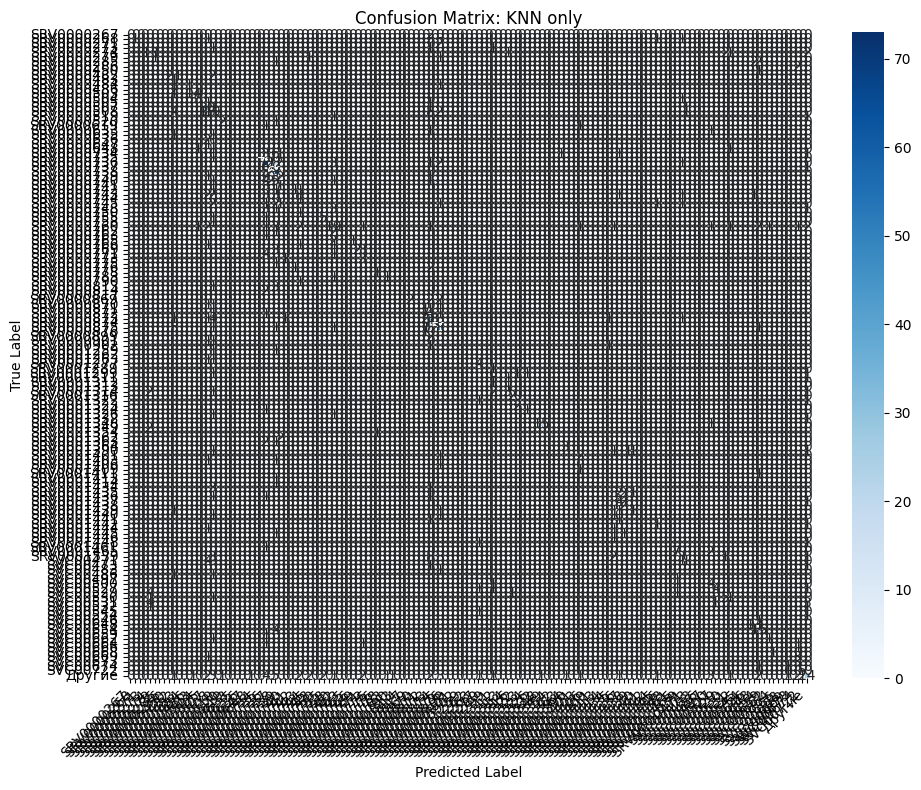

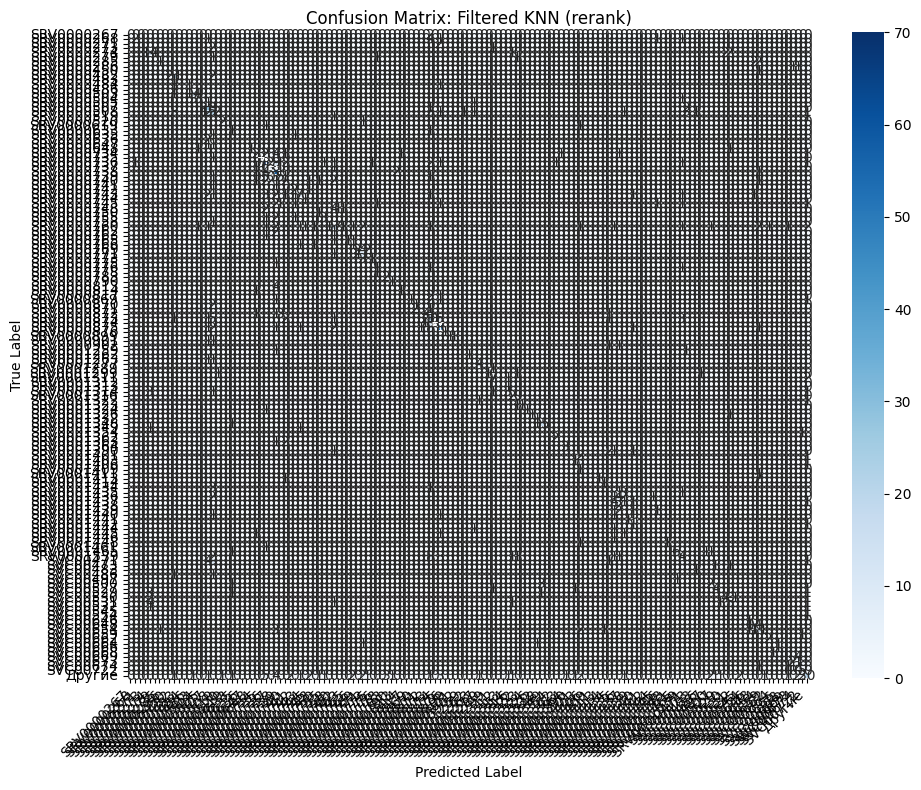

Done.


In [5]:
"""
Расширенный клаccификационный пайплайн с тремя подходами:
1) KNNClassifierService — классический KNN по FAISS, взвешенный по cosine (L2-нормированные эмбеддинги).
2) RerankerAggregatorService — KNN + reranker, где веса соседей из BGE-reranker складываются по классам.
3) FilteredKNNService — KNN + фильтрация reranker’ом, затем KNN по оставшимся с учётом FAISS-схожести.

Входные данные: CSV "/home/vadim/vadim/request_classifier/data/new/combined.csv"
- Колонки "Тема" + "Описание" → объединяем в одну строку `text`.
- Колонка "НОМЕР" → исходные метки.

Принцип работы FilteredKNNService:
1. Находим k ближайших соседей по FAISS (как в классическом KNN).
2. Считаем reranker-счёт для каждой пары (query, neighbor_text).
3. Фильтруем из соседей тех, у кого reranker-score < THRESHOLD_RERANK (например, 0.2).
4. Если после фильтрации остались соседи:
     - Аггрегируем original FAISS-оценки (cosine) по классам среди оставшихся,
       нормируем на сумму и выдаём распределение.
     - Предсказываем класс с наибольшей суммой FAISS-оценок.
   Иначе (если все соседи отфильтрованы):
     - Фолбэк на классический KNN (предсказание по тому, что близкие соседи были без фильтрации).

Оценка: считаем Accuracy и Macro-F1 для всех трёх методов, строим confusion matrix.

Зависимости:
    pip install pandas numpy scikit-learn transformers torch faiss-cpu matplotlib seaborn tqdm

Запуск:
    python classify_three_services.py
"""

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import faiss
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

###############################################################################
#                               НАСТРОЙКИ                                      #
###############################################################################

CSV_PATH = "/home/vadim/vadim/request_classifier/data/new/combined.csv"

TEXT_COLS = ["Тема", "Описание"]
TARGET_COL = "НОМЕР"

EMBEDDING_MODEL = "intfloat/multilingual-e5-large"
RERANKER_MODEL  = "BAAI/bge-reranker-large"

K_NEIGHBORS = 50
TEST_SIZE = 0.1
RANDOM_STATE = 42

MAX_LENGTH = 512
BATCH_SIZE = 32

RARE_THRESHOLD = 10  # классы с частотой < 10 группируем в "Другие"
THRESHOLD_RERANK = 0.2  # фильтровать соседей reranker-score < 0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

###############################################################################
#                         ФУНКЦИИ ДЛЯ ЭМБЕДДИНГОВ                             #
###############################################################################

def embed_texts_e5(texts: list[str],
                   tokenizer_e5: AutoTokenizer,
                   model_e5: AutoModel,
                   batch_size: int = BATCH_SIZE,
                   device: str = DEVICE) -> np.ndarray:
    """
    Кодируем список текстов в эмбеддинги (1024) с помощью intfloat/multilingual-e5-large.
    Возвращаем L2-нормированные вектора shape = [len(texts), 1024].
    """
    all_embeds = []
    model_e5.eval()
    for i in tqdm(range(0, len(texts), batch_size), desc="E5 Embedding"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer_e5(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model_e5(**encoded, return_dict=True)
        last_hidden = outputs.last_hidden_state  # [B, T, 1024]

        mask = encoded["attention_mask"].unsqueeze(-1)  # [B, T, 1]
        masked = last_hidden * mask                    # [B, T, 1024]
        summed = masked.sum(dim=1)                      # [B, 1024]
        lengths = mask.sum(dim=1)                       # [B, 1]
        embeds = (summed / lengths).cpu().numpy()       # [B, 1024]

        all_embeds.append(embeds)

    all_embeds = np.vstack(all_embeds)  # [N, 1024]
    norms = np.linalg.norm(all_embeds, axis=1, keepdims=True) + 1e-12
    all_embeds = all_embeds / norms
    return all_embeds

###############################################################################
#                       СЕРВИСЫ КЛАССИФИКАЦИИ                                  #
###############################################################################

class KNNClassifierService:
    """
    Классический KNN через FAISS, взвешивает соседей по cosine (inner-product).
    """
    def __init__(self, train_vecs: np.ndarray, train_labels: np.ndarray, k: int = K_NEIGHBORS):
        self.k = k
        self.train_labels = train_labels
        # FAISS-индекс
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def predict_one(self, query_vec: np.ndarray, num_classes: int) -> tuple[int, np.ndarray]:
        """
        Для одного вектора query_vec возвращает (pred_label, distribution).
        Распределение строится как взвешенные cosine-схожести по классам.
        """
        qv = query_vec.reshape(1, -1).astype(np.float32)
        similarities, indices = self.index.search(qv, self.k)
        sims = similarities[0]         # [k]
        neigh_ids = indices[0].tolist()  # [k]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]

        # Агрегируем cosine-схожести по классам
        class_scores = np.zeros(num_classes, dtype=float)
        total_sim = 0.0
        for lbl, sim in zip(neigh_labels, sims):
            class_scores[lbl] += sim
            total_sim += sim

        if total_sim <= 1e-12:
            # fallback: простое голосование
            counts = Counter(neigh_labels)
            pred = counts.most_common(1)[0][0]
            dist = np.zeros(num_classes, dtype=float)
            for lbl, cnt in counts.items():
                dist[lbl] = cnt / self.k
        else:
            pred = int(np.argmax(class_scores))
            dist = class_scores / total_sim

        return pred, dist

    def predict(self, query_vecs: np.ndarray, num_classes: int) -> tuple[np.ndarray, np.ndarray]:
        preds = []
        dists = []
        for vec in query_vecs:
            p, dist = self.predict_one(vec, num_classes)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)


class RerankerAggregatorService:
    """
    KNN + reranker: берём k соседей, rerank’им каждого, агрегируем rerank-оценки по классам.
    """
    def __init__(self,
                 train_vecs: np.ndarray,
                 train_labels: np.ndarray,
                 train_texts: List[str],
                 tokenizer_rerank: AutoTokenizer,
                 model_rerank: AutoModelForSequenceClassification,
                 k: int = K_NEIGHBORS,
                 device: str = DEVICE):
        self.k = k
        self.train_labels = train_labels
        self.train_texts = train_texts
        self.tokenizer_rerank = tokenizer_rerank
        self.model_rerank = model_rerank.to(device)
        self.device = device

        # FAISS-индекс
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def rerank_scores(self, query: str, neighbor_texts: List[str]) -> List[float]:
        self.model_rerank.eval()
        pairs = [(query, doc) for doc in neighbor_texts]
        encoded = self.tokenizer_rerank.batch_encode_plus(
            pairs,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model_rerank(**encoded)
        logits = outputs.logits.cpu().numpy()  # [k, num_labels]

        if logits.shape[1] == 2:
            exp = np.exp(logits)
            probs = exp[:, 1] / exp.sum(axis=1)
            return probs.tolist()
        else:
            return logits[:, 0].tolist()

    def predict_one(self, query_vec: np.ndarray, query_text: str, num_classes: int) -> tuple[int, np.ndarray]:
        qv = query_vec.reshape(1, -1).astype(np.float32)
        sims, indices = self.index.search(qv, self.k)
        neigh_ids = indices[0].tolist()
        neigh_texts = [self.train_texts[idx] for idx in neigh_ids]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]

        scores = self.rerank_scores(query_text, neigh_texts)  # [k]

        class_scores = np.zeros(num_classes, dtype=float)
        for lbl, sc in zip(neigh_labels, scores):
            class_scores[lbl] += sc

        total = class_scores.sum()
        if total <= 1e-12:
            dist = np.ones(num_classes, dtype=float) / num_classes
            pred = np.random.randint(0, num_classes)
        else:
            dist = class_scores / total
            pred = int(np.argmax(dist))

        return pred, dist

    def predict(self, query_vecs: np.ndarray, query_texts: List[str], num_classes: int) -> tuple[np.ndarray, np.ndarray]:
        preds = []
        dists = []
        for vec, txt in zip(query_vecs, query_texts):
            p, dist = self.predict_one(vec, txt, num_classes)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)


class FilteredKNNService:
    """
    KNN + фильтрация reranker’ом:
    1) Находим k соседей по FAISS.
    2) Получаем rerank-оценки для каждого.
    3) Фильтруем: оставляем лишь тех соседей, чьи rerank-оценки >= THRESHOLD_RERANK.
    4) Если осталось > 0 соседей:
         - Агрегируем оригинальные FAISS-схожести (cosine) по классам среди оставшихся.
         - Нормируем суммы и это – распределение.
         - Класс = argmax распределения.
       Иначе:
         - Фолбэк на классический KNN (Voting + cosine).
    """
    def __init__(self,
                 train_vecs: np.ndarray,
                 train_labels: np.ndarray,
                 train_texts: List[str],
                 tokenizer_rerank: AutoTokenizer,
                 model_rerank: AutoModelForSequenceClassification,
                 k: int = K_NEIGHBORS,
                 threshold: float = THRESHOLD_RERANK,
                 device: str = DEVICE):
        self.k = k
        self.threshold = threshold
        self.train_labels = train_labels
        self.train_texts = train_texts
        self.tokenizer_rerank = tokenizer_rerank
        self.model_rerank = model_rerank.to(device)
        self.device = device

        # FAISS-индекс
        d = train_vecs.shape[1]
        self.index = faiss.IndexFlatIP(d)
        self.index.add(train_vecs.astype(np.float32))

    def rerank_scores(self, query: str, neighbor_texts: List[str]) -> List[float]:
        self.model_rerank.eval()
        pairs = [(query, doc) for doc in neighbor_texts]
        encoded = self.tokenizer_rerank.batch_encode_plus(
            pairs,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model_rerank(**encoded)
        logits = outputs.logits.cpu().numpy()  # [k, num_labels]

        if logits.shape[1] == 2:
            exp = np.exp(logits)
            probs = exp[:, 1] / exp.sum(axis=1)
            return probs.tolist()
        else:
            return logits[:, 0].tolist()

    def predict_one(self, query_vec: np.ndarray, query_text: str, num_classes: int) -> tuple[int, np.ndarray]:
        qv = query_vec.reshape(1, -1).astype(np.float32)
        sims, indices = self.index.search(qv, self.k)
        sims = sims[0]        # [k]
        neigh_ids = indices[0].tolist()  # [k]
        neigh_texts = [self.train_texts[idx] for idx in neigh_ids]
        neigh_labels = [self.train_labels[idx] for idx in neigh_ids]

        rerank_scores = self.rerank_scores(query_text, neigh_texts)  # [k]

        # Фильтрация соседей
        kept_indices = [i for i, score in enumerate(rerank_scores) if score >= self.threshold]

        if kept_indices:
            # Если остаются соседи после фильтрации
            class_scores = np.zeros(num_classes, dtype=float)
            total_sim = 0.0
            for i in kept_indices:
                lbl = neigh_labels[i]
                sim = sims[i]  # оригинальная FAISS-схожесть
                class_scores[lbl] += sim
                total_sim += sim

            if total_sim <= 1e-12:
                # fallback: частотное голосование среди kept_indices
                kept_labels = [neigh_labels[i] for i in kept_indices]
                counts = Counter(kept_labels)
                pred = counts.most_common(1)[0][0]
                dist = np.zeros(num_classes, dtype=float)
                for lbl, cnt in counts.items():
                    dist[lbl] = cnt / len(kept_indices)
            else:
                pred = int(np.argmax(class_scores))
                dist = class_scores / total_sim

        else:
            # Фолбэк: классический KNN по всем k соседям (без фильтрации reranker)
            # Агрегируем cosine-схожести по классам
            class_scores = np.zeros(num_classes, dtype=float)
            total_sim = 0.0
            for lbl, sim in zip(neigh_labels, sims):
                class_scores[lbl] += sim
                total_sim += sim

            if total_sim <= 1e-12:
                counts = Counter(neigh_labels)
                pred = counts.most_common(1)[0][0]
                dist = np.zeros(num_classes, dtype=float)
                for lbl, cnt in counts.items():
                    dist[lbl] = cnt / self.k
            else:
                pred = int(np.argmax(class_scores))
                dist = class_scores / total_sim

        return pred, dist

    def predict(self, query_vecs: np.ndarray, query_texts: List[str], num_classes: int) -> tuple[np.ndarray, np.ndarray]:
        preds = []
        dists = []
        for vec, txt in tqdm(zip(query_vecs, query_texts), total=len(query_texts)):
            p, dist = self.predict_one(vec, txt, num_classes)
            preds.append(p)
            dists.append(dist)
        return np.array(preds, dtype=int), np.vstack(dists)

###############################################################################
#                         ФУНКЦИИ ДЛЯ ВИЗУАЛИЗАЦИИ                             #
###############################################################################

def plot_confusion(cm: np.ndarray, class_labels: List[str], title: str):
    """
    Строит график confusion matrix с метками.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

###############################################################################
#                                    MAIN                                      #
###############################################################################

if __name__ == "__main__":
    # 1) Загрузка CSV
    print("Loading CSV...")
    df = pd.read_csv(CSV_PATH)
    for col in TEXT_COLS + [TARGET_COL]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in CSV")

    # 2) Комбинирование "Тема" + "Описание"
    print("Combining text columns...")
    df["text"] = df[TEXT_COLS[0]].fillna("") + " " + df[TEXT_COLS[1]].fillna("")

    # 3) Преобразование меток
    if not pd.api.types.is_integer_dtype(df[TARGET_COL].dtype):
        try:
            df[TARGET_COL] = df[TARGET_COL].astype(int)
        except:
            df[TARGET_COL] = df[TARGET_COL].astype(str)
    original_labels = df[TARGET_COL].tolist()
    texts = df["text"].tolist()

    # 4) Группировка редких классов
    print(f"Grouping classes with frequency < {RARE_THRESHOLD} into 'Другие'...")
    freq = Counter(original_labels)
    grouped_labels = []
    for lab in original_labels:
        if freq[lab] < RARE_THRESHOLD:
            grouped_labels.append("Другие")
        else:
            grouped_labels.append(lab)

    # 5) Список уникальных классов после группировки
    freq_grouped = Counter(grouped_labels)
    unique_classes = sorted(freq_grouped.keys())
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    y = np.array([class_to_idx[l] for l in grouped_labels], dtype=int)
    n_classes = len(unique_classes)
    print(f"Total samples: {len(texts)}, Unique classes after grouping: {n_classes}")

    # 6) Разбиение на train/test
    print("Splitting into train/test...")
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Train size: {len(X_train_texts)}, Test size: {len(X_test_texts)}")

    # 7) Загрузка E5 и кодирование текстов
    print(f"Loading E5 model ({EMBEDDING_MODEL}) ...")
    tokenizer_e5 = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)
    model_e5 = AutoModel.from_pretrained(EMBEDDING_MODEL).to(DEVICE)

    print("Embedding train texts with E5...")
    X_train_vecs = embed_texts_e5(X_train_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)
    print("Embedding test texts with E5...")
    X_test_vecs = embed_texts_e5(X_test_texts, tokenizer_e5, model_e5, batch_size=BATCH_SIZE, device=DEVICE)

    # 8) Инициализация сервисов
    print("Initializing KNNClassifierService...")
    knn_service = KNNClassifierService(train_vecs=X_train_vecs, train_labels=y_train, k=K_NEIGHBORS)

    print(f"Loading reranker model ({RERANKER_MODEL}) ...")
    tokenizer_rerank = AutoTokenizer.from_pretrained(RERANKER_MODEL)
    model_rerank = AutoModelForSequenceClassification.from_pretrained(RERANKER_MODEL).to(DEVICE)

    print("Initializing RerankerAggregatorService...")
    rerank_agg_service = RerankerAggregatorService(
        train_vecs=X_train_vecs,
        train_labels=y_train,
        train_texts=X_train_texts,
        tokenizer_rerank=tokenizer_rerank,
        model_rerank=model_rerank,
        k=K_NEIGHBORS,
        device=DEVICE
    )

    print("Initializing FilteredKNNService...")
    filtered_knn_service = FilteredKNNService(
        train_vecs=X_train_vecs,
        train_labels=y_train,
        train_texts=X_train_texts,
        tokenizer_rerank=tokenizer_rerank,
        model_rerank=model_rerank,
        k=K_NEIGHBORS,
        threshold=THRESHOLD_RERANK,
        device=DEVICE
    )

    # 9) Предсказания на тестовой выборке
    print("Classifying test samples with all three services...")
    preds_knn, dists_knn = knn_service.predict(X_test_vecs, n_classes)
    # preds_rerank, dists_rerank = rerank_agg_service.predict(X_test_vecs, X_test_texts, n_classes)
    preds_filtered, dists_filtered = filtered_knn_service.predict(X_test_vecs, X_test_texts, n_classes)

    # 10) Оценка качества
    y_true = y_test

    # KNN only
    acc_knn = accuracy_score(y_true, preds_knn)
    f1_knn  = f1_score(y_true, preds_knn, average="macro")

    # KNN + RerankerAggregated
    # acc_rerank_agg = accuracy_score(y_true, preds_rerank)
    # f1_rerank_agg  = f1_score(y_true, preds_rerank, average="macro")

    # Filtered KNN
    acc_filtered = accuracy_score(y_true, preds_filtered)
    f1_filtered  = f1_score(y_true, preds_filtered, average="macro")

    print("\n===== Results =====")
    print(f"KNN only              : Accuracy = {acc_knn:.4f}, Macro-F1 = {f1_knn:.4f}")
    # print(f"KNN + Rerank-aggregate: Accuracy = {acc_rerank_agg:.4f}, Macro-F1 = {f1_rerank_agg:.4f}")
    print(f"Filtered KNN (rerank): Accuracy = {acc_filtered:.4f}, Macro-F1 = {f1_filtered:.4f}")

    print("\n--- Classification Report for KNN only ---")
    print(classification_report(y_true, preds_knn, target_names=unique_classes))

    # print("\n--- Classification Report for KNN + Rerank-aggregate ---")
    # print(classification_report(y_true, preds_rerank, target_names=unique_classes))

    print("\n--- Classification Report for Filtered KNN (rerank) ---")
    print(classification_report(y_true, preds_filtered, target_names=unique_classes))

    # 11) Построение confusion matrix
    cm_knn = confusion_matrix(y_true, preds_knn)
    # cm_rerank_agg = confusion_matrix(y_true, preds_rerank)
    cm_filtered = confusion_matrix(y_true, preds_filtered)

    plot_confusion(cm_knn, unique_classes, title="Confusion Matrix: KNN only")
    # plot_confusion(cm_rerank_agg, unique_classes, title="Confusion Matrix: KNN + Rerank-aggregate")
    plot_confusion(cm_filtered, unique_classes, title="Confusion Matrix: Filtered KNN (rerank)")

    print("Done.")
